In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [3]:
path_base = '../data/10x_CD8TC/'
path_merged = path_base + 'merged_tcr_10x.h5ad'
path_filtered = path_base + 'filtered_tcr_10x.h5ad'
path_logged = path_base + 'logged_10x.h5ad'
path_highlyvar = path_base + 'highly_var_5000.h5ad'
path_clean_split = path_base + 'v5_train_val_test.h5ad'
path_supervised = path_base + 'v6_supervised.h5ad'
path_avidity = path_base + 'v7_avidity.h5ad'

## Merge Files

The 10x VDJ dataset consists of CD8+ T cells from for donor. First, transcriptome data is merged with tcr information. In a second step, the data is fused over all donors. In the third step, the measured binding affinity is merged.

In [4]:
adatas = []
batch_names = []
for i in range(1, 5):
    # Transcriptome data
    file_name = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)
    
    # TCR data
    path_anno = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
    anno_tcr = ir.io.read_10x_vdj(path_anno)    
    ir.pp.merge_with_ir(adata_tmp, anno_tcr)
        
    # Binding data
    path_binding = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)

    for k in binarized_matrix.columns:
        adata_tmp.obs[k] = None
        adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
    
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)
    batch_names.append(f'donor_{i}')
    
adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)
sc.write(adata=adata, filename=path_merged)

reading ../data/10x_CD8TC/patient_1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
reading ../data/10x_CD8TC/patient_2/vdj_v1_hs_aggregate

... storing 'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder' as categorical
... storing 'A0201_KVAELVHFL_MAGE-A3_Cancer_binder' as categorical
... storing 'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder' as categorical
... storing 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder' as categorical
... storing 'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder' as categorical
... storing 'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder' as categorical
... storing 'A0201_CLGGLLTMV_LMP-2A_EBV_binder' as categorical
... storing 'A0201_YLLEMLWRL_LMP1_EBV_binder' as categorical
... storing 'A0201_FLYALALLL_LMP2A_EBV_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0201_NLVPMVATV_pp65_CMV_binder' as categorical
... storing 'A0201_ILKEPVHGV_RT_HIV_binder' as categorical
... storing 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder' as categorical
... storing 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder' as categorical
... st

In [5]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 237883
With IR-Info: 189512


In [6]:
# 237883
adata.obs['donor'].value_counts()

donor_2    91921
donor_1    55206
donor_3    54137
donor_4    36619
Name: donor, dtype: int64

# Qualitiy control

Load data and calculate the amount of counts, genes and fraction of mitochondrial genes.

In [7]:
adata = sc.read(path_merged)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

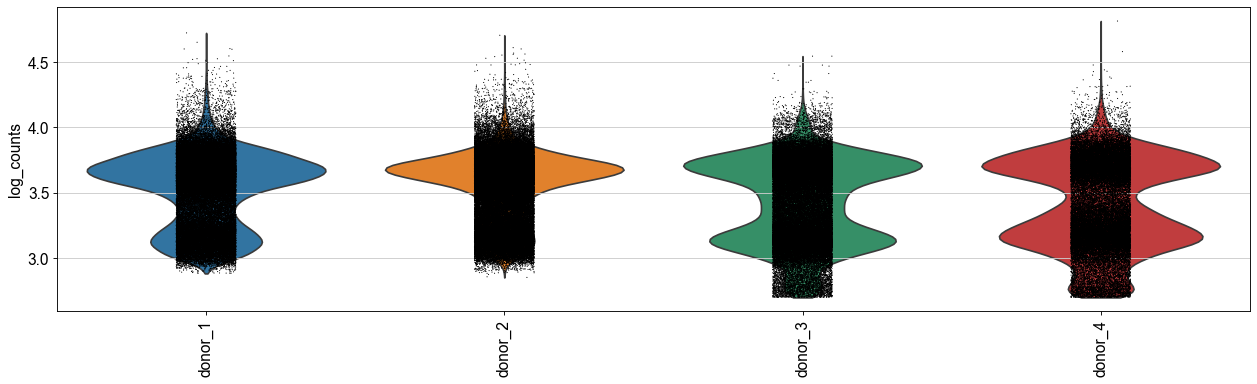

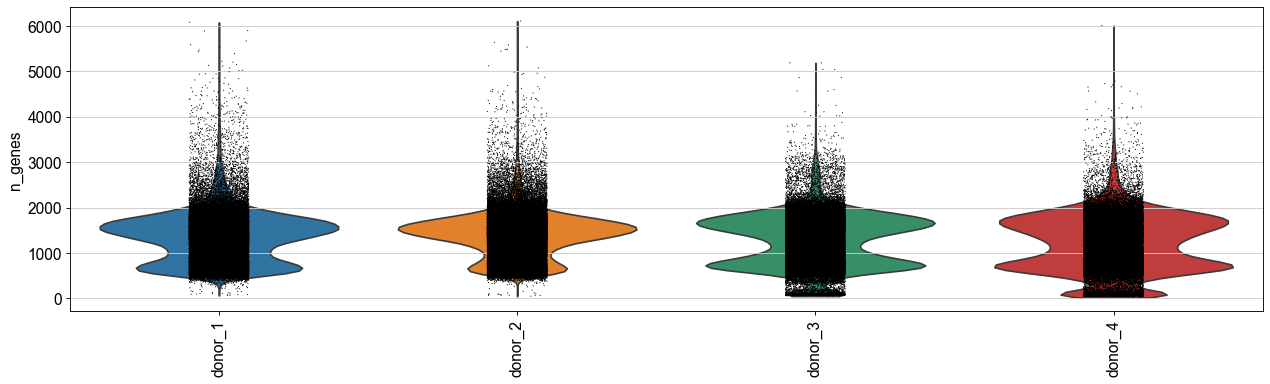

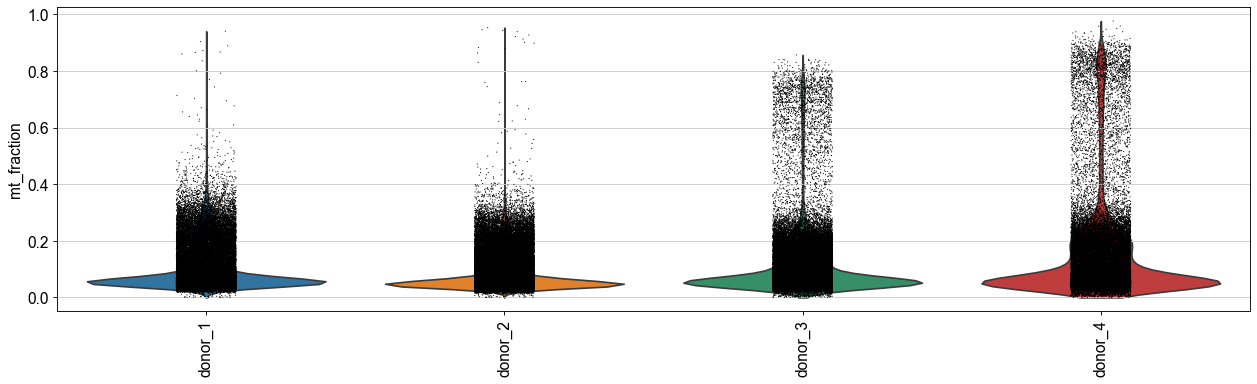

In [8]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

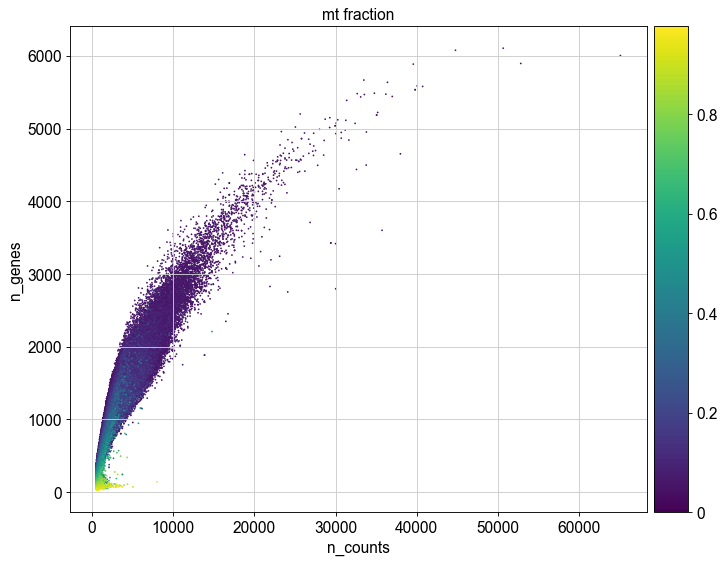

In [9]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes:title={'center':'donor'}, xlabel='n_counts', ylabel='n_genes'>

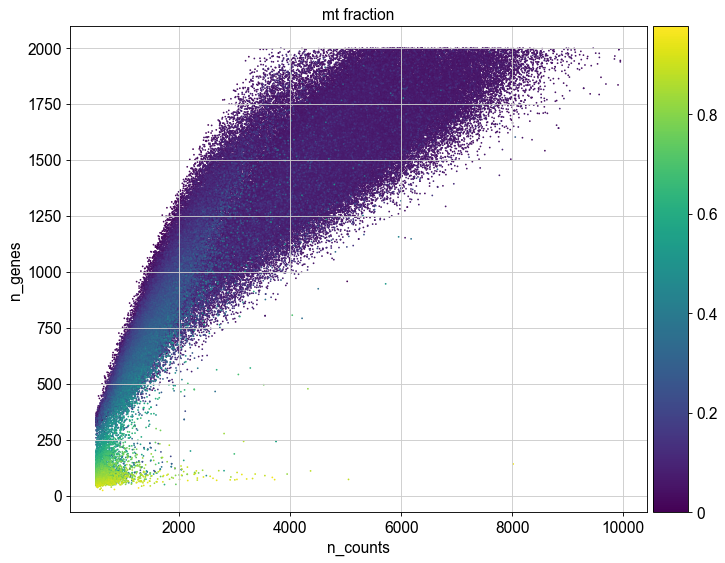

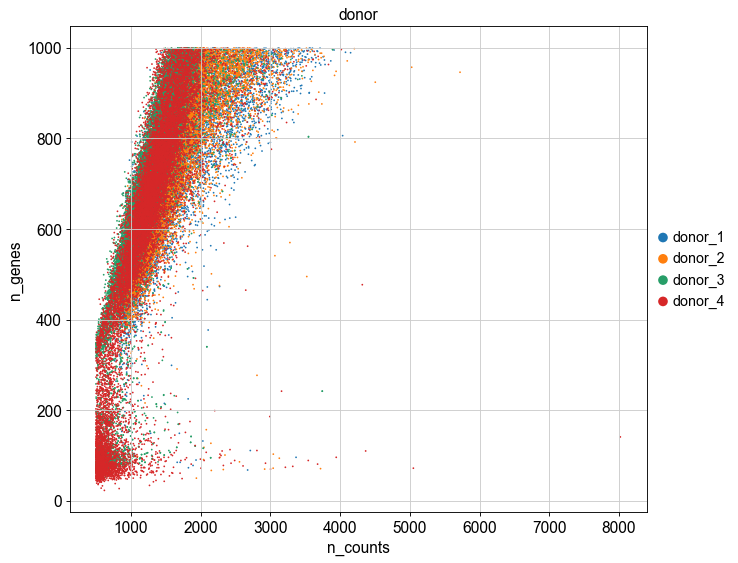

In [10]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

## Cell Filtering

Filter cells by the following indicators:
- fraction of mitochondrial genes (max)
- gene count (min, max)
- gene count (max)

Filter genes by:
- amount of cells representing this gene (min)


Mitochondrial filter: The fraction of mt genes to all genes is high for cell with membrane leakage.

In [11]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2  #todo why this value
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 237883
Number of cells after MT filter: 208593


Gene-Count Filter between 1000 and 10.000

In [12]:
low_count = adata_tmp.obs['n_counts'] > 1000
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')

sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximum filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 204696


filtered out 3268 cells that have more than 10000 counts
Trying to set attribute `.obs` of view, copying.


Number of cells after maximum filter: 201428


Gene-Count Filter: filter out cells with low gene count < 500

In [13]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 201235


Gene-Filter: filter out genes that are represented in less than 10 cells

In [14]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

filtered out 13831 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


Number of cells after gene filter: 19707


## Doublet detection

In droplet based methods multiple cells might be present in a drop. The droplet score is evaluated by Scrublet.

In [15]:
import scrublet as scr
import scipy.io
import time

In [16]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [17]:
# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx, :].X,
                        n_neighbors = n_neighbors,
                        sim_doublet_ratio = sim_doublet_ratio,
                        expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                              min_cells = min_cells,
                                                              n_prin_comps = n_pc,
                                                              use_approx_neighbors = True,
                                                              get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor_1')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 44.8%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 61.6 seconds
Elapsed time: 63.5 seconds
(1, 'donor_2')


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 34.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.1%
Elapsed time: 103.4 seconds
Elapsed time: 106.9 seconds
(2, 'donor_3')


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 42.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.9%
Elapsed time: 56.9 seconds
Elapsed time: 58.9 seconds
(3, 'donor_4')


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 45.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 38.3 seconds
Elapsed time: 39.7 seconds


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='doublet_score'>

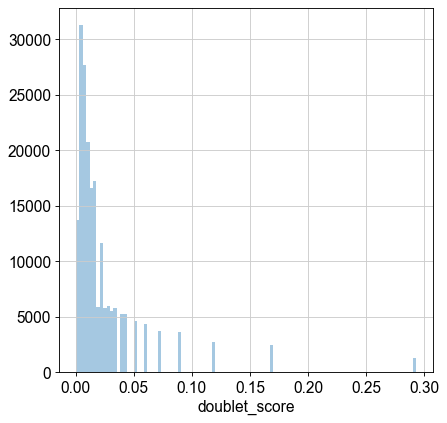

In [18]:
rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

... storing 'doublet' as categorical


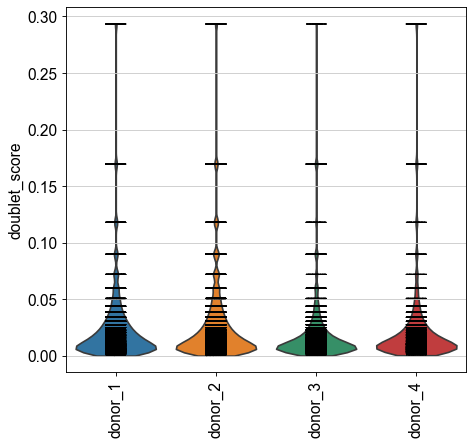

In [19]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False, rotation=90)

In [20]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr

adata_tmp = adata_tmp[idx_filter].copy()
print(f'Number of cells after double filter: {adata_tmp.n_obs}')

Number of cells after double filter: 178356


## QC after filtering

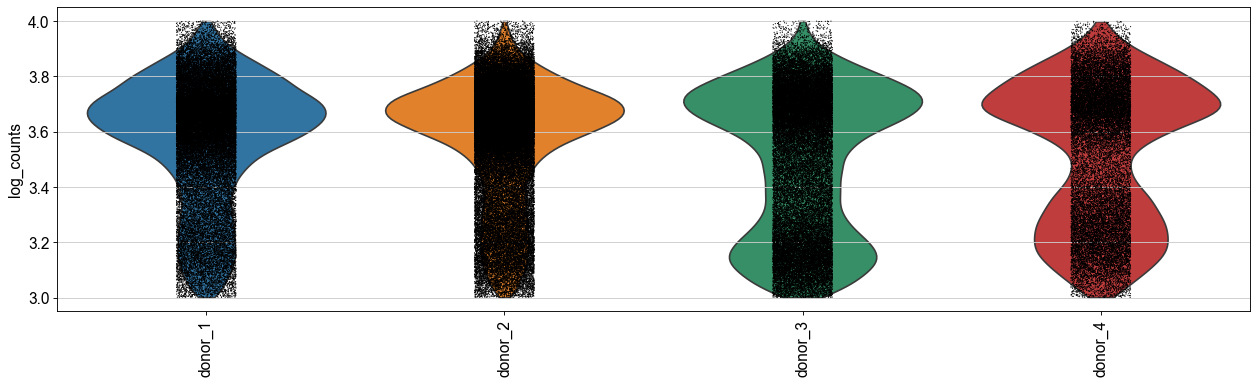

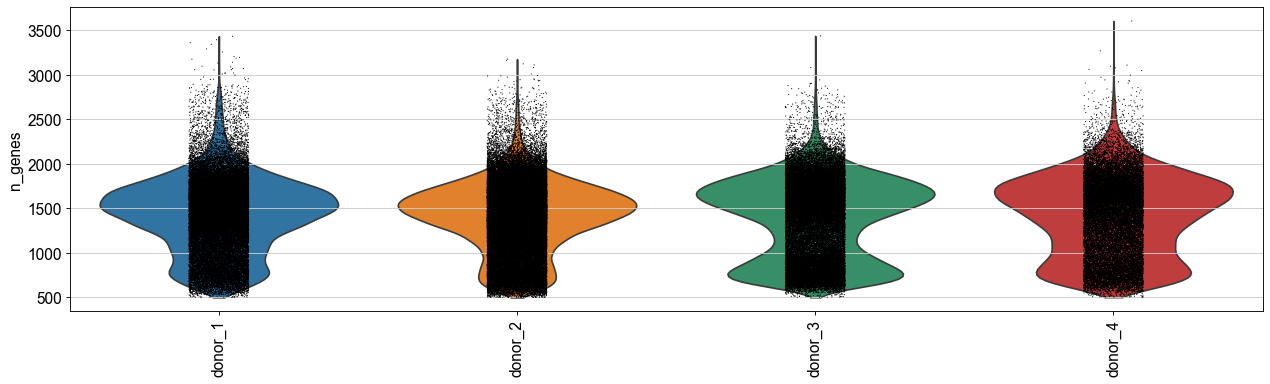

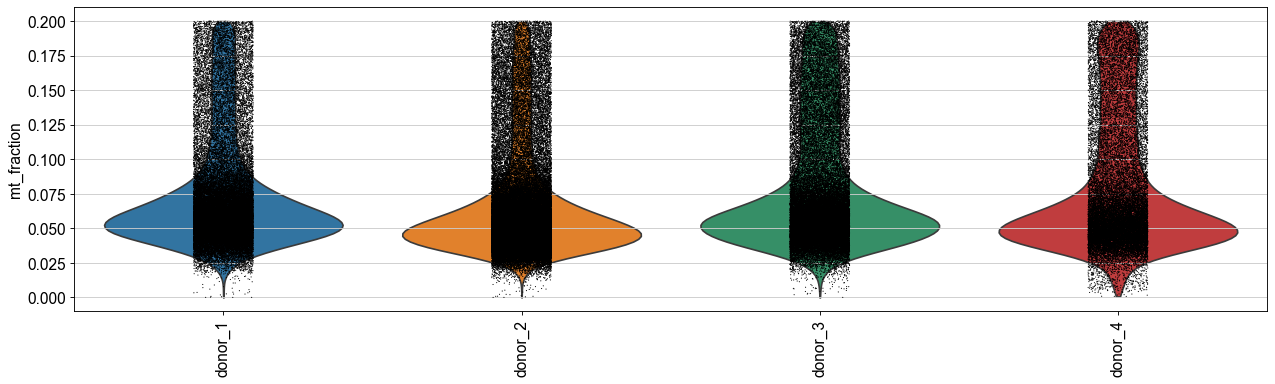

In [21]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

In [22]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values, 
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index, 
                      columns=['mean_genes'])

df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
donor,,,,
donor_1,1428.021586,1472.0,4243.854492,4265.0
donor_2,1409.451561,1462.0,4178.091797,4335.0
donor_3,1384.667215,1484.0,3716.381592,3774.0
donor_4,1412.311165,1474.0,3916.064209,4040.0


In [23]:
sc.write(adata=adata_tmp, filename=path_filtered)

## Simple normalization


In [24]:
adata_tmp = sc.read(path_filtered)

In [25]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata_tmp)

normalizing counts per cell
    finished (0:00:01)


In [26]:
sc.write(adata=adata_tmp, filename=path_logged)

## Highly variable Gens

In [27]:
adata_tmp = sc.read(path_logged)

In [28]:
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor')
print('Shape before: ', adata_tmp.shape)
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
print('Shape after: ', adata_tmp.shape)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Shape before:  (178356, 19707)
Shape after:  (178356, 5000)


In [29]:
sc.write(adata=adata_tmp, filename=path_highlyvar)

## Model Specific Preproccessing


### Further TC cleaning

Clean cells without or multiple IR information. Filter out chains without paired TRA and TRB (None).

In [30]:
adata = sc.read_h5ad(path_highlyvar)

In [31]:
print('All cells: ', adata.shape)
adata = adata[adata.obs['has_ir'] == 'True']
print('With IRs: ', adata.shape)
adata = adata[adata.obs['multi_chain'] == 'False']
print('With 1 IR set: ', adata.shape)
adata = adata[(adata.obs['IR_VJ_1_cdr3'] != 'None') & (adata.obs['IR_VJ_1_cdr3'] != 'nan') & 
              (adata.obs['IR_VDJ_1_cdr3'] != 'None') & (adata.obs['IR_VDJ_1_cdr3'] != 'nan')]
print('With full IR:', adata.shape)

All cells:  (178356, 5000)
With IRs:  (152149, 5000)
With 1 IR set:  (152002, 5000)
With full IR: (128587, 5000)


### Clonotype annotation

The clonotype annotation from 10x defines clonotypes not accross all donors. Therefor, public TCRs might leak between training and testing data. Further, cells with the same TCR but multiple IRs are classified as different clonotypes. We therefor assign own clonotype labels based on complete correspondence based on alpha and beta chain.

In [32]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].head()

Trying to set attribute `.obs` of view, copying.


51213


AAACGGGAGAAGATTC-1-donor_1    0
AAACGGGTCGGACAAG-1-donor_1    1
AAAGATGGTACAGACG-1-donor_1    2
AAAGTAGAGACGCTTT-1-donor_1    3
AAAGTAGAGCGCTTAT-1-donor_1    4
Name: clonotype, dtype: int64

### Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [33]:
import sys
sys.path.append('../')
import tcr_embedding.utils_preprocessing as utils

In [34]:
adata.obs['TRA+TRB'] = adata.obs['IR_VJ_1_cdr3'].astype(str) + '+' + adata.obs['IR_VDJ_1_cdr3'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

45

In [35]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)


In [36]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

(128587, 47)
(128587, 47, 24)
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}


### Antigen Binding Encoding

Process the Binding Specificity to form that it easy to use during training.

In [37]:
antigen_binding_list = [x for x in adata.obs.columns if x.endswith('_binder')]
binding_matrix = (adata.obs[antigen_binding_list] == 'True').values.astype(int)
binding_matrix.shape

(128587, 50)

In [38]:
unique_value, count = np.unique(binding_matrix.sum(axis=1), return_counts=True)
for unique_value_, count_ in zip(unique_value, count):
    print(f'Cells with {unique_value_} bindings: {count_}')

Cells with 0 bindings: 66816
Cells with 1 bindings: 61771


In [39]:
label_to_binding = {label_id: antigen for label_id, antigen in enumerate(antigen_binding_list)}
label_to_binding[-1] = 'no_data'  # For cells without binding data
binding_to_label = {antigen: label_id for label_id, antigen in enumerate(antigen_binding_list)}
binding_to_label['no_data'] = -1
binding_to_label == {v: k for k, v in label_to_binding.items()}  # sanity check, if both dicts are the reverse of each other

True

In [40]:
adata.obs['has_binding'] = binding_matrix.sum(axis=1).astype(bool)
adata.obs['has_binding'].head()

AAACGGGAGAAGATTC-1-donor_1     True
AAACGGGTCGGACAAG-1-donor_1    False
AAAGATGGTACAGACG-1-donor_1    False
AAAGTAGAGACGCTTT-1-donor_1    False
AAAGTAGAGCGCTTAT-1-donor_1    False
Name: has_binding, dtype: bool

In [41]:
adata.obs['binding_label'] = np.argmax(binding_matrix, axis=1)
adata.obs['binding_label'][~adata.obs['has_binding']] = -1
adata.obs['binding_label'].head()

C:\Users\FELIX~1.DRO\AppData\Local\Temp/ipykernel_20916/3710922540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['binding_label'][~adata.obs['has_binding']] = -1


AAACGGGAGAAGATTC-1-donor_1    29
AAACGGGTCGGACAAG-1-donor_1    -1
AAAGATGGTACAGACG-1-donor_1    -1
AAAGTAGAGACGCTTT-1-donor_1    -1
AAAGTAGAGCGCTTAT-1-donor_1    -1
Name: binding_label, dtype: int64

In [42]:
adata.obs['binding_name'] = adata.obs['binding_label'].map(label_to_binding)
adata.obs['binding_name'].head()

AAACGGGAGAAGATTC-1-donor_1    A0301_KLGGALQAK_IE-1_CMV_binder
AAACGGGTCGGACAAG-1-donor_1                            no_data
AAAGATGGTACAGACG-1-donor_1                            no_data
AAAGTAGAGACGCTTT-1-donor_1                            no_data
AAAGTAGAGCGCTTAT-1-donor_1                            no_data
Name: binding_name, dtype: object

### Test-Validation Split
We don't want to include the same clonotype in the different splits. Further we want to have the same data distribution in donor and antigen binding dimension to have faithful results.

Therefore we need stratification (similar label distribution across the sets) and grouped sampling (groups, i.e. the same clonotype is only present in one set)

In [43]:
adata.obs['donor+binding'] = adata.obs['donor'].astype(str) + '_' + adata.obs['binding_name'].astype(str)
adata.obs['donor+binding'].sample(10)

GTGCTTCCAGGGTACA-9-donor_1                                     donor_1_no_data
TCGTACCCAATAGCGG-32-donor_2                                    donor_2_no_data
ACGATACCAGAAGCAC-19-donor_2            donor_2_A0301_KLGGALQAK_IE-1_CMV_binder
TGAGGGATCAGTCAGT-14-donor_2                                    donor_2_no_data
CCTTCGAGTCATGCCG-2-donor_3             donor_3_A0301_KLGGALQAK_IE-1_CMV_binder
CACAGGCAGAACTCGG-26-donor_2            donor_2_A0301_KLGGALQAK_IE-1_CMV_binder
AGAGCGACAAGCCTAT-31-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
GCTGGGTAGGTGGGTT-11-donor_3            donor_3_A0301_KLGGALQAK_IE-1_CMV_binder
CAGGTGCTCTGAGTGT-22-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
TGCGGGTGTCTAGAGG-10-donor_2    donor_2_A0201_GILGFVFTL_Flu-MP_Influenza_binder
Name: donor+binding, dtype: object

In [44]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = utils.stratified_group_shuffle_split(adata.obs, stratify_col='donor+binding', group_col='clonotype', val_split=0.20, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = utils.stratified_group_shuffle_split(train_val, stratify_col='donor+binding', group_col='clonotype', val_split=0.25, random_seed=random_seed)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:03<00:00, 29.47it/s]


In [45]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  87642
Train Ratio:  0.6815774533973108
Val Samples:  19987
Val Ratio:  0.15543561946386494
Test Samples:  20958
Test Ratio:  0.1629869271388243


#### Visualize Distribution

Logarithmic scale

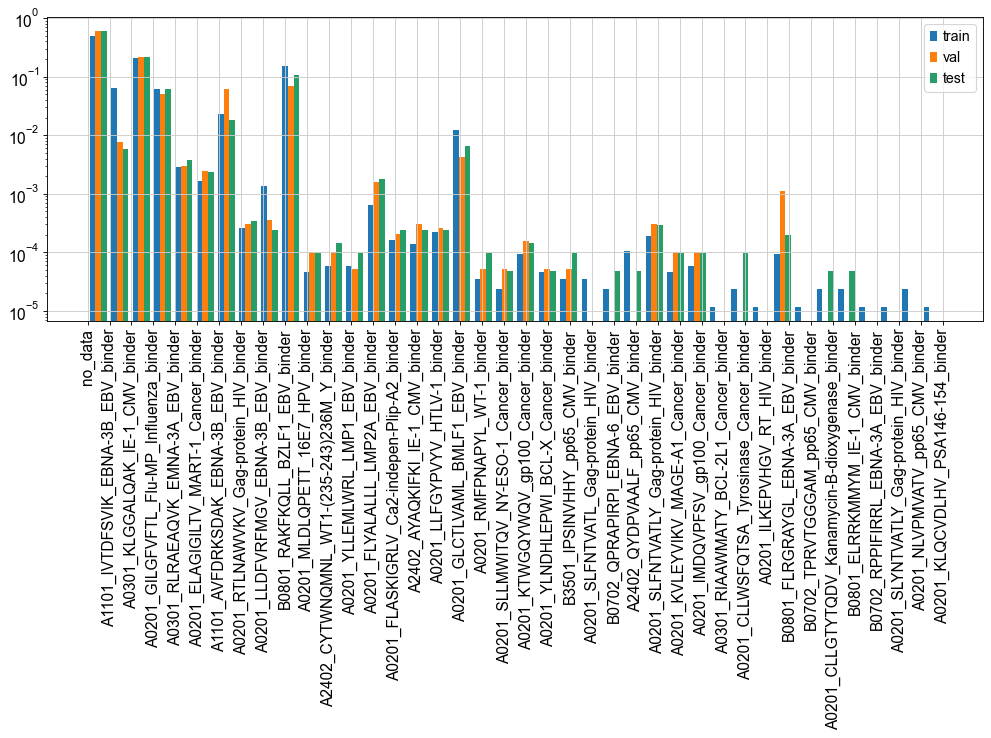

In [46]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

Linear scale

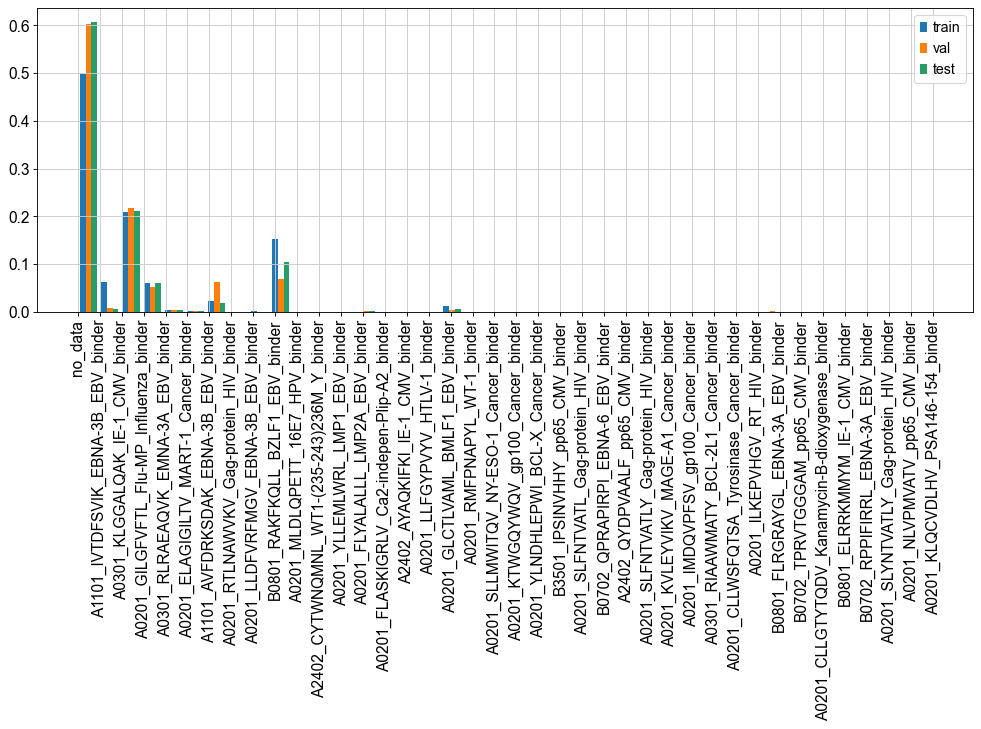

In [47]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

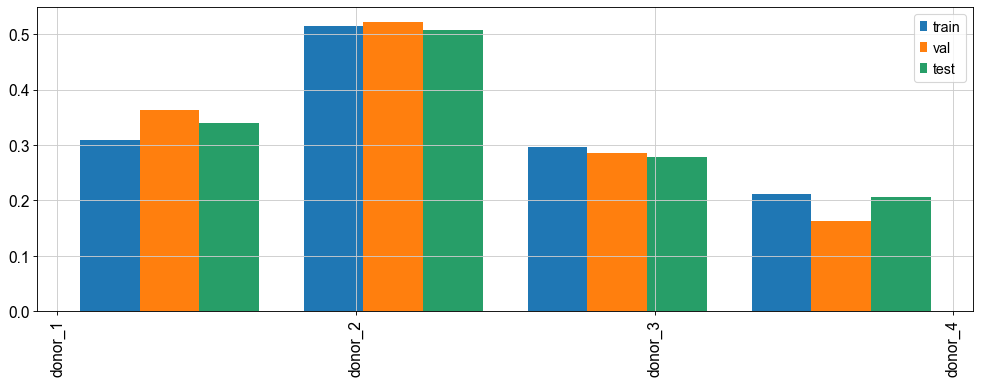

In [48]:
pl.figure(figsize=(15,5))
pl.hist([train['donor'], val['donor'], test['donor']], density=True, bins=len(train['donor'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

#### Check if clonotypes are unique within each set

In [49]:
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty\n')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))
# print('\nSanity Check - Intersection in clonotypes between train and train: ', form_train.intersection(form_train))

Intersection in clonotypes between two sets should be empty

Intersection in clonotypes between train and test:  set()
Intersection in clonotypes between train and val:  set()
Intersection in clonotypes between val and test:  set()


#### Save resulting split

In [50]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

train    87642
test     20958
val      19987
Name: set, dtype: int64

In [51]:
adata.obs['set'].sample(20)

GAACATCGTAATCGTC-3-donor_1     train
TACTTGTAGAGCTATA-7-donor_3      test
AGAGCTTAGTCTCAAC-6-donor_3       val
GCATGCGGTTCTCATT-5-donor_4     train
GCCAAATCATTAGGCT-7-donor_4     train
GCAGCCACATGACATC-2-donor_4     train
CCTACACTCTTGACGA-20-donor_2     test
GTTACAGTCCTAGGGC-38-donor_2     test
CAGCCGAGTGCTAGCC-27-donor_2    train
TATCTCATCTAGAGTC-30-donor_1    train
CGATGTAAGTGTGAAT-4-donor_4     train
CTGAAGTAGCCCTAAT-3-donor_1      test
GTCACGGTCTCGCATC-23-donor_1    train
AGGGATGAGGCCCTCA-23-donor_2    train
GACGTGCCAAGTTGTC-5-donor_4       val
GTGCAGCAGATGTAAC-11-donor_3    train
AGTGGGATCAGTTTGG-5-donor_1     train
AAGTCTGCACATGTGT-13-donor_1    train
AAGCCGCGTCAAACTC-12-donor_3    train
TACTTGTCATGGGAAC-40-donor_1      val
Name: set, dtype: object

In [52]:
adata.write_h5ad(path_clean_split, compression='gzip')

... storing 'TRA+TRB' as categorical
... storing 'binding_name' as categorical
... storing 'donor+binding' as categorical
... storing 'set' as categorical


## Supervised and Semi-supervised preprocessing
Add prediction labels to adata

In [15]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [54]:
adata = sc.read_h5ad(path_clean_split)

In [55]:
adata.obs[['binding_name', 'binding_label']]

,binding_name,binding_label
AAACGGGAGAAGATTC-1-donor_1,A0301_KLGGALQAK_IE-1_CMV_binder,29
AAACGGGTCGGACAAG-1-donor_1,no_data,-1
AAAGATGGTACAGACG-1-donor_1,no_data,-1
AAAGTAGAGACGCTTT-1-donor_1,no_data,-1
AAAGTAGAGCGCTTAT-1-donor_1,no_data,-1
...,...,...
TTTGTCAGTACCCAAT-8-donor_4,no_data,-1
TTTGTCAGTCTAAACC-8-donor_4,no_data,-1
TTTGTCAGTCTCTCGT-8-donor_4,no_data,-1
TTTGTCATCCCACTTG-8-donor_4,no_data,-1


In [14]:
import config.constants_10x as constants
high_count_antigens = constants.HIGH_COUNT_ANTIGENS.copy()
high_count_antigens

ModuleNotFoundError: No module named 'config'

In [57]:
adata.obs['high_count_binding_name'] = adata.obs['binding_name']
# Set rare antigen specificities to 'no_data'
adata.obs['high_count_binding_name'][~adata.obs['high_count_binding_name'].isin(high_count_antigens)] = 'no_data'
adata.obs['high_count_binding_name'] = adata.obs['high_count_binding_name'].astype(str)
adata.obs['high_count_binding_name'].unique()

array(['A0301_KLGGALQAK_IE-1_CMV_binder', 'no_data',
       'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
       'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
       'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
       'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
       'A0201_ELAGIGILTV_MART-1_Cancer_binder',
       'B0801_RAKFKQLL_BZLF1_EBV_binder',
       'A0201_GLCTLVAML_BMLF1_EBV_binder'], dtype=object)

In [58]:
# Use this high_count_antigens list to be consistent with the order (alphabetical)
high_count_antigens += ['no_data']
specificity_to_label = {k: v for v, k in enumerate(high_count_antigens)}
label_to_specificity = {k: v for k, v in enumerate(high_count_antigens)}
adata.uns['specificity_to_label'] = specificity_to_label
adata.uns['label_to_specificity'] = label_to_specificity
specificity_to_label

{'A0201_ELAGIGILTV_MART-1_Cancer_binder': 0,
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 1,
 'A0201_GLCTLVAML_BMLF1_EBV_binder': 2,
 'A0301_KLGGALQAK_IE-1_CMV_binder': 3,
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 4,
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 5,
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 6,
 'B0801_RAKFKQLL_BZLF1_EBV_binder': 7,
 'no_data': 8}

In [59]:
label_to_specificity

{0: 'A0201_ELAGIGILTV_MART-1_Cancer_binder',
 1: 'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
 2: 'A0201_GLCTLVAML_BMLF1_EBV_binder',
 3: 'A0301_KLGGALQAK_IE-1_CMV_binder',
 4: 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
 5: 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
 6: 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
 7: 'B0801_RAKFKQLL_BZLF1_EBV_binder',
 8: 'no_data'}

In [60]:
adata.obs['high_count_binding_label'] = adata.obs['high_count_binding_name'].map(specificity_to_label)
adata.obs['high_count_binding_label'].value_counts()

8    67350
3    26347
7    16478
1     7380
5     5657
6     3510
2     1244
4      380
0      241
Name: high_count_binding_label, dtype: int64

In [61]:
aa_to_id = adata.uns['aa_to_id']
utils.aa_encoding(adata, read_col='IR_VJ_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=26, aa_to_id=aa_to_id, start_end_symbol=False)

In [62]:
adata.obsm['alpha_seq']

array([[ 2,  1, 11, ...,  0,  0,  0],
       [ 2,  1, 15, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  0,  0,  0],
       ...,
       [ 2,  8, 10, ...,  0,  0,  0],
       [ 2,  1, 18, ...,  0,  0,  0],
       [ 2,  6,  1, ...,  0,  0,  0]])

In [63]:
adata.write_h5ad(path_supervised, compression='gzip')

... storing 'high_count_binding_name' as categorical


## Add avidity information

In [4]:
import sys
sys.path.append('../')
import config.constants_10x as const

In [5]:
adata = sc.read(path_supervised)

In [6]:
cols_binder_counts = const.HIGH_COUNT_ANTIGENS
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]

In [7]:
binding_counts = []
for donor in range(1, 5):
    path_binding = f'../data/10x_CD8TC/patient_{donor}/vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
    binarized_matrix.index.name = None
    binarized_matrix = binarized_matrix[cols_binder_counts]
    binarized_matrix.index = binarized_matrix.index + f'-donor_{donor}'
    binding_counts.append(binarized_matrix)
binding_counts = pd.concat(binding_counts)

In [8]:
binding_counts = binding_counts.loc[adata.obs.index]
adata.obsm['binding_counts'] = binding_counts.values

In [9]:
adata.write_h5ad(path_avidity, compression='gzip')